[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CAMM-UTK/acns-AI-tutorial/blob/main/Diffraction_ML/XTEC_with_GMM.ipynb)

# Xray Temperature Clustering (XTEC)

## Harnessing Interpretable and Unsupervised Machine Learning to Address Big Data from Modern X-ray Diffraction

[GitHub](https://github.com/KimGroup/X-TEC)

[PNAS](https://www.pnas.org/doi/abs/10.1073/pnas.2109665119)
[arXiv](https://arxiv.org/abs/2008.03275)

### Authors

Jordan Venderley<sup>1</sup>, Krishnanand Mallaya<sup>1</sup>, Michael Matty<sup>1</sup>, Matthew Krogstad<sup>2</sup>, Jacob Ruff<sup>3</sup>, Geoff Pleiss<sup>4</sup>, Varsha Kishore<sup>4</sup>, David Mandrus<sup>5</sup>, Daniel Phelan<sup>2</sup>, Lekh Poudel<sup>6,7</sup>, Andrew Gordon Wilson<sup>8</sup>, Kilian Weinberger<sup>4</sup>, Puspa Upreti<sup>2,9</sup>, M. R. Norman<sup>2</sup>, Stephan Rosenkranz<sup>2</sup>, Raymond Osborn<sup>2</sup>, Eun-Ah Kim<sup>1*</sup>

### Affiliations

1. Department of Physics, Cornell University
2. Materials Science Division, Argonne National Laboratory
3. Cornell High Energy Synchrotron Source, Cornell University
4. Department of Computer Science, Cornell University
5. Department of Materials Science and Engineering, University of Tennessee
6. Department of Materials Science and Engineering, University of Maryland
7. NIST Center for Neutron Research, National Institute of Standard and Technology
8. Courant Institute of Mathematical Sciences, New York University
9. Department of Physics, Northern Illinois University

---

### Tutorial by Krishnanand Mallayya

For questions about X-TEC code and tutorial, please contact:
- **Email**: kmm537@cornell.edu
- **Name**: Krishnanand Mallayya

The massive data that modern facilities generate spanning 3D reciprocal space volumes include $\sim 10^4$ Brillouin zones (BZ) at rates of $\sim 10^2$ gigabytes per hour. The sheer quantity of data presents a major challenge in searching for unknown order parameters and their fluctuations. Here,  we will find how clustering with Gaussian Mixture Model uncovers the underlying physics from the diffraction data.

When the temperature $T$ is lowered below a certain threshold, the system can give way to an ordered state. Hence the temperature ($T$) evolution of the X-ray diffraction (XRD) intensity: $I(\vec{q}, T)$ for the reciprocal space points $\vec{q}$ must be qualitatively different from the rest when $\vec{q}$ is associated with an order parameter or its fluctuations. 

Manually tracking the temperature evolution of thousands of Brillouin zones to identify systematic trends and correlations in a comprehensive manner is manually challenging. **XTEC** is an unsupervised ML algorithm utilizing the Gaussian Mixture Model to identify the clusters of distinct temperature dependencies, and their locations in the diffraction data. 



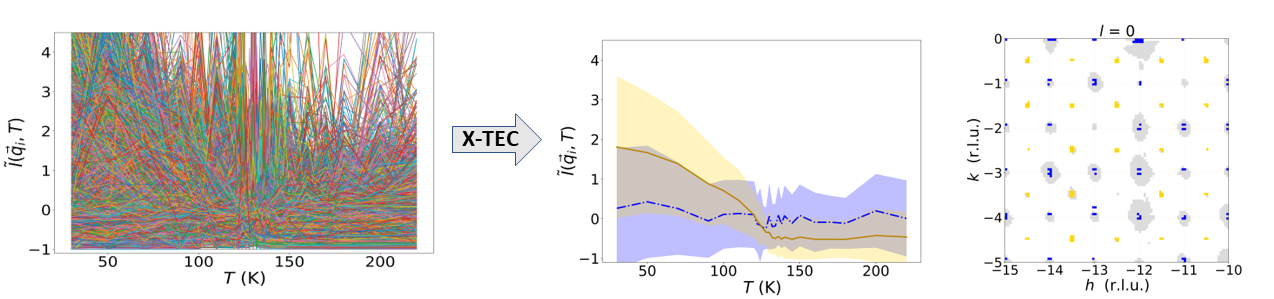



Apart from temperature series data, you can adapt XTEC to analyze diffraction data evolving under a parameter like time or energy series data.      


# 1. X-TEC analysis of Sr$_3$Rh$_4$Sn$_{13}$ XRD data

In this notebook, we analyze the XRD data of Sr$_3$Rh$_4$Sn$_{13}$ which undergoes a charge density wave (CDW) transition at ~138K.

## 1.1 Setting Up

**Clone the XTEC Repository** to access the required modules into colab



In [ ]:
!git clone https://github.com/KimGroup/X-TEC.git

**Import the required modules** 

In [ ]:
import sys
sys.path.append('X-TEC/src/xtec/')

from Preprocessing import Mask_Zeros, Threshold_Background
from GMM import GMM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

## 1.2 Load the X-ray diffraction data


The XRD data is a temperature series of intensities measured at (Qh, Qk, Ql) points in the 3D reciprocal lattice. It is a numpy array with shape (num_Temperature, num_Ql, num_Qk, num_Qh) 

While the precise values of Qh, Qk, and Ql are beneficial for plotting and identifying pixel locations in reciprocal space, they are not essential for the clustering analysis itself.

In this example, we focus on a small **2D** slice of the reciprocal space, specifically the (Qh, Qk, 0) plane at various temperatures. The full 3D XRD temperature series data (~32 Gb) is available at https://dx.doi.org/10.18126/iidy-30e7.  The data was measured on sector 6-ID-D at the Advanced Photon Source. 

In [ ]:
import pickle

!wget -O Raw_data.p  https://www.dropbox.com/scl/fi/pfhl3r6f1kxd4wqjsgzbx/Raw_data.p?rlkey=oeulorixew1eq1s01qb51al6s&dl=0

obj = pickle.load(open("Raw_data.p", "rb"))
I=obj['Data']
Tlist=obj['Temp']
Qh=obj['Qh']
Qk=obj['Qk']



In [ ]:
print('(num_T, num_h, num_k)=',I.shape)   # (num_T, num_k, num_h)
print('Temperatures (K)=',Tlist)
print('Ql = 0')
print('Qk =', Qk[0],' to ',np.round(Qk[-1],4), ' r.l.u. per pixel=',np.round(Qk[1]-Qk[0],4))
print('Qh =', Qh[0],' to ',np.round(Qh[-1],4), ' r.l.u. per pixel=',np.round(Qh[1]-Qh[0],4))

### Plotting a section of the the raw data to see the CDW  peaks at low temperatures

In [ ]:
iT=0
plt.figure(figsize=(3,3))
plt.imshow(np.log(1+I[iT][200:300,0:100]),origin="lower",extent=[Qk[0], Qk[100], Qh[200], Qh[300]])
plt.xlabel("Q$_h$",size=15)
plt.ylabel("Q$_k$",size=15)
plt.title('T='+ str(Tlist[iT])+'K',size=15);


iT=-1
plt.figure(figsize=(3,3))
plt.imshow(np.log(1+I[iT][200:300,0:100]),origin="lower",extent=[Qk[0], Qk[100], Qh[200], Qh[300]])
plt.xlabel("Q$_h$",size=15)
plt.ylabel("Q$_k$",size=15)
plt.title('T='+ str(Tlist[iT])+'K',size=15);


Notice the CDW peaks at half integer positions: $(Qh,Qk,Ql)=(H+0.5,K+0.5,0)$ at $T=30$K. These peaks are absent at $220$K.    

#  X-TEC Analysis

We go through these following steps 

**Preprocessing**

The data undergoes initial preprocessing to remove low-intensity noise. This is followed by a rescaling to bring the intensities of the peaks and diffuse scattering on the same scale, to better reveal their temperature trajectory.

**Clustering**

The preprocessed data is clustered using a Gaussian Mixture Model (GMM) to identify distinct temperature trajectories.

**Interpretation**

From the clustered results, we identify various features: 
- CDW peaks
- Order parameter 

**Improving results**

More sensible results can be obtained by suppressing the pixel-to pixel noise inherent in experimental data.
We apply a Gaussian filter to enforce local smoothness to the raw images, and then repeat the XTEC analysis to  find cleaner results.

## 1.3 Preprocessing: Remove low intensity background

Remove low intensity background noise. Assumes that the peaks/relevant
x-ray features are sparse so that most momenta have predominantely background intensity contributions.

Cutoff is estimated by minimizing the Kullback-Leibler (KL) divergence between the distribution of temperature averaged pixel intensities: $\log[\overline{I_q(T)}]$ and a Gaussian distribution with (high intensity) sliding cutoff.   

See [preprocessing.py](https://github.com/KimGroup/XTEC/blob/main/src/xtec/Preprocessing.py) for the code, and SM section 1.B in [PNAS](https://www.pnas.org/doi/abs/10.1073/pnas.2109665119)


In [ ]:
# First remove zero intensity points from the data

masked    = Mask_Zeros(I) 

In [ ]:
# threshold the background intensity

threshold = Threshold_Background(masked)


data_post_thresh = threshold.data_thresholded  # shape=(num_temperatures, num_thresholded data)
print('num of original non zero data=', np.prod(threshold.data_shape_orig[1:]))
print('num of thresholded data=', data_post_thresh.shape[1])

Let us see the thresholding results.

Below is the $\log[\overline{I_q(T)}]$ distribution and the Gaussian fit with high intensity cutoff estimated from minimising KL distance.

In [ ]:
figsize_=(7,3)
threshold.plot_cutoff(figsize_)

Note the non Gaussian features in the distribution just above the cutoff intensity (red dot). 

All data points that have $\log[\overline{I_q(T)}]$ above estimated cutoff are retained. 

The plot below shows those remaining points in the hk plane as grey clusters  

In [ ]:
figsize_=(4,4)
threshold.plot_thresholding_2D_slice(figsize_)

ax = plt.gca()
ax.get_images()[0].set_extent((Qh[0], Qh[-1], Qk[0], Qk[-1])) 
plt.xlabel(r'$Q_h$')
plt.ylabel(r'$Q_k$')
plt.title(f'$Q_l$=0');


All the grey pixels have intensities above the background cutoff and are retained

Let's plot a few temperature trajectories of intensities that pass the thresholding.

In [ ]:
plt.figure(figsize=(5,4))
for i in range(1000):
  plt.plot(Tlist,data_post_thresh[:,i]);
plt.xlabel('T',size=20)
plt.ylabel('$I_q(T)$',size=20);

Notice the large range of intensities. This shows that we need rescaling to reduce the large range and for efficient feature selection of the temperature trajectory.

## 1.4 Preprocessing: rescale intensities

To reduce the large range in the scale of intensities and for efficient feature selection of the temperature trajectory, here are two options for rescaling $I_q(T)$: 


- Rescaling by mean:
subtracting and dividing their mean over temperature $\mu_{\vec{q}_i}=d_T^{-1}\sum_j I_{\vec{q}_i}(T_j)$  for each $q$,


\begin{eqnarray}
	\tilde{I}_{\vec{q}_i}(T_j)=\dfrac{I_{\vec{q}_i}(T_j)}{\mu_{\vec{q}_i}}-1,\label{eq:mean_rescaling}
	\end{eqnarray}
    
    
- Z-scoring the data:
subtracting the mean (over T) and then dividing by standard deviation (over T) 
    
\begin{eqnarray}
	\tilde{I}_{\vec{q}_i}(T_j)=\dfrac{I_{\vec{q}_i}(T_j)-\mu_{\vec q_i}}{\sigma_{\vec{q}_i}},
\end{eqnarray}
    
where $\sigma_{\vec{q}_i}=\sqrt{d_T^{-1}\sum_j \left(I_{\vec{q}_i}(T_j)-\mu_{\vec q_i}\right)^2}$ is the standard deviation.
	
We will go by the first option (Rescaling by mean), which is often effective in revealing order parameters.


In [ ]:
# get rescaled intensity by subtracting and dividing by the mean over T:
Rescaled_data=(data_post_thresh-np.mean(data_post_thresh,axis=0))/np.mean(data_post_thresh,axis=0)

In [ ]:
print('num T = ', Rescaled_data.shape[0], ' num of thresholded (and rescaled) data = ', Rescaled_data.shape[1] )

In [ ]:
plt.figure(figsize=(5,4))
for i in range(5000):
  plt.plot(Tlist,Rescaled_data[:,i]);
plt.xlabel('T',size=20)
plt.ylabel('$I_q(T)$',size=20);
plt.ylim([-1,10])

# 2 GMM clustering

Use GMM algorithm to cluster the preprocessed data (rescaled data).

See [GMM.py](https://github.com/KimGroup/XTEC/blob/main/src/xtec/GMM.py) for details. The code uses Step-wise Expectation Maximization algorithm  (cf. Liang and Klein 2009) to cluster data.

### 2.1 Set number of clusters

In [ ]:
num_clusters = 4                              # change this to 3, 4, 5 etc and explore.

In [ ]:
Temp            = np.array(Tlist)             # temperature list
Data_for_GMM    = Rescaled_data.transpose()       # data should be arranged as (num_data,num_T) 

### 2.2 Fit the GMM

In [ ]:
clusterGMM = GMM(Data_for_GMM,num_clusters) 
clusterGMM.RunEM()                          
print('num of trajectories in each cluster: [num_red, num_blue,num_green,num_violet]=', clusterGMM.num_per_cluster)

Clustering results are stored in clusterGMM as

```
clusterGMM.cluster_assignments : cluster assignment k in range(num_clusters), of each sample. Shape=(num_data)
clusterGMM.num_per_cluster : number of trajectories in each cluster.

clusterGMM.cluster[k].mean: cluster mean trajectory (dim=num_Temperature) of the k-th cluster
clusterGMM.cluster[k].cov : cluster covariance [dim=num_Temperature] of the k-th cluster
```

### 2.3 Visualize the results

Let us plot the mean trajectory with 1 standard deviation shaded, for the clusters (color coded as red blue green violet etc.).

In [ ]:
clusterGMM.Plot_Cluster_Results_traj(Temp)  # Plotting for only less than 7 clusters currently enabled.  

plt.xlabel('T(K)', size=18)
plt.ylabel('$\widetilde{I}_q(T)$', size=18)
plt.title('Cluster mean and variance \n (rescaled) intensity trajectory ');

**The order parameter** like behavior of one of the cluster is apparent from here, with a transition temperature $T_c\approx 130 K$ This cluster corresponds to the CDW peak. 

To see that, let us plot and see which pixels in the $(Q_h,Q_k)$ plane belong to the red/blue/green/violet cluster.   

In [ ]:
Data_ind=threshold.ind_thresholded   # shape=(num_high_std_dev_data,2),give the (h,k) indices of the thresholded data

figsize_ = (6,6)

clusterGMM.Plot_Cluster_kspace_2D_slice(threshold, figsize_, Data_ind) 

plt.xlabel("Q$_h$",size=20)
plt.ylabel("Q$_k$",size=20)
plt.title('Q$_l$=0',size=20);




**Zooming in the above figure..**


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(clusterGMM.plot_image[200:300,0:100],origin='lower',cmap=clusterGMM.plot_cmap,norm=clusterGMM.plot_norm,extent=[Qk[0], Qk[100], Qh[200], Qh[300]])
plt.xlabel("Q$_h$",size=20)
plt.ylabel("Q$_k$",size=20)
plt.title('Q$_l$=0',size=20)



Notice that CDW peaks at $q_{CDW} = (H+0.5,K+0.5,0)$ have overwhelmingly the same color matching the color of the order parameter like trajectory.

We can also see the Bragg peaks and the diffuse scattering surrounding them, distinguished by the clusters.

### 3. Improving results


Due to experimental noise, there is some degree of pixel-to pixel fluctuations. We can enforce local smoothness by convolution of the original raw image with a Gaussian filter (using scipy). 

In [ ]:
from scipy.ndimage import gaussian_filter


In [ ]:
# Gaussian smoothing
sigma= 0.5 # lengthscale for smoothing in units of pixel

sigma = (0,sigma,sigma)  # Standard deviation for Gaussian kernel (Temp axis is not smoothed) 

Smooth_I= gaussian_filter(I, sigma=sigma)


#### Redo the analysis: Preprocessing, and GMM with smooth data

In [ ]:
masked    = Mask_Zeros(Smooth_I) 
threshold = Threshold_Background(masked)
Rescaled_data=threshold.Rescale_mean(threshold.data_thresholded)

In [ ]:
num_clusters = 4                              # change this to 3, 4, 5 etc and explore.

In [ ]:
Temp            = np.array(Tlist)             # temperature list
Data_for_GMM    = Rescaled_data.transpose()       # data should be arranged as (num_data,num_T) 

In [ ]:
smooth_GMM = GMM(Data_for_GMM,num_clusters) 
smooth_GMM.RunEM()                          
print('num of trajectories in each cluster: [num_red, num_blue,num_green,num_violet]=', clusterGMM.num_per_cluster)

Let us plot the cluster trajectories

In [ ]:
smooth_GMM.Plot_Cluster_Results_traj(Temp)  # Plotting for only less than 7 clusters currently enabled.  

plt.xlabel('T(K)', size=18)
plt.ylabel('$\widetilde{I}_q(T)$', size=18)
plt.title('Cluster mean and variance \n (rescaled) intensity trajectory ');

We now see a sharp cluster revealing the CDW order parameter. Let us plot and see which pixels in the  (ℎ,𝑘)  plane belong to this clustering assignments.

In [ ]:
Data_ind=threshold.ind_thresholded   # shape=(num_high_std_dev_data,2),give the (h,k) indices of the thresholded data

figsize_ = (6,6)

smooth_GMM.Plot_Cluster_kspace_2D_slice(threshold, figsize_, Data_ind) 

plt.xlabel("Q$_h$",size=20)
plt.ylabel("Q$_k$",size=20)
plt.title('Q$_l$=0',size=20);




In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(smooth_GMM.plot_image[200:300,0:100],origin='lower',cmap=clusterGMM.plot_cmap,norm=clusterGMM.plot_norm,extent=[Qk[0], Qk[100], Qh[200], Qh[300]])
plt.xlabel("Q$_h$",size=20)
plt.ylabel("Q$_k$",size=20)
plt.title('Q$_l$=0',size=20)


Now, we have smooth labels (colors). All CDW peaks have one color, matching that of the order parameter trajectory, while Bragg peaks have the other color.

